In [11]:
#Kathrin Fischer
import yt
import matplotlib.pyplot as plt
from astropy import units as u, constants  as c
import numpy as np
from unyt import cm, s, erg, K, sr
pc = c.pc.cgs.value
kB  = c.k_B.cgs.value
Msun = c.M_sun.cgs.value
G = c.G.cgs.value
Myr = u.Myr.in_units("s")
eV = 1.60218e-12   # eV in erg

In [9]:
def _j_halpha_R(field, data):
    T = data[("gas", "temperature")].v
    T4 = T / 1e4
    number_density = data[("gas", "number_density")].v
    ion_fraction = data[("flash", "ihp ")].v
    ne_np = (number_density * ion_fraction) ** 2
    return 2.82e-26 * (T4 ** (-0.942 - 0.03 * np.log(T4))) * ne_np * erg / cm**3 / s / sr

def _j_halpha_C(field, data):
    T = data[("gas", "temperature")].v
    number_density = data[("gas", "number_density")].v
    ion_fraction = data[("flash", "ihp ")].v
    Ha_fraction = data[("flash", "iha ")]
    ne = number_density * ion_fraction
    nH = number_density * Ha_fraction
        
    def lambda_13(T):
        if 4000 <= T <= 25000:
            return 0.35 - 2.62e-7*T - 8.15e-11*T**2 + 6.19e-15*T**3
        elif 25000 < T <= 500000:
            return 0.276 + 4.99e-6*T - 8.85e-12*T**2 + 7.18e-18*T**3
        elif T < 4000:
            T = 4000
            return 0.35 - 2.62e-7*T - 8.15e-11*T**2 + 6.19e-15*T**3
        elif T > 500000: 
            T = 500000
            return 0.276 + 4.99e-6*T - 8.85e-12*T**2 + 7.18e-18*T**3
    
    lambda_13_vec = np.vectorize(lambda_13)
    return (1.30e-17 / (4 * np.pi)) * (lambda_13_vec(T) / np.sqrt(T)) * np.exp(-12.1 * eV / kB /  T) * ne * nH * erg / cm**3 / s / sr

"""def _j_halpha_vol_R(field, data):
    j_halpha_R = data[("gas", "j_halpha_R")]
    cell_volume = data[("gas", "cell_volume")]
    return j_halpha_R * cell_volume

def _j_halpha_vol_C(field, data):
    j_halpha_C = data[("gas", "j_halpha_C")]
    cell_volume = data[("gas", "cell_volume")]
    return j_halpha_C * cell_volume"""

def _j_halpha_RC(field, data):
    j_halpha_R = data[("gas", "j_halpha_R")]
    j_halpha_C = data[("gas", "j_halpha_C")]
    #return (j_halpha_R + j_halpha_C) * 4 * np.pi
    return (j_halpha_R + j_halpha_C) 

def _compute_radial_data(ds, r0, r1, Nr, ctr):
    radii = np.linspace(r0, r1, Nr)
    masses_tot = np.zeros(Nr)
    masses_ihp = np.zeros(Nr)
    masses_iha = np.zeros(Nr)
    masses_ih2 = np.zeros(Nr)
    total_j_halpha_RC = np.zeros(Nr)
    total_j_halpha_R = np.zeros(Nr)
    total_j_halpha_C = np.zeros(Nr)
    
    for i, r_p in enumerate(radii):
        sph_p = ds.sphere(ctr, (r_p, "pc"))
        rho = sph_p[("gas", "density")]
        vol = sph_p[("gas", "cell_volume")]
        ihp = sph_p[("flash", "ihp ")]
        ih2 = sph_p[("flash", "ih2 ")]
        iha = sph_p[("flash", "iha ")]
        j_halpha_R = sph_p[("gas", "j_halpha_R")]
        j_halpha_C = sph_p[("gas", "j_halpha_C")]
        j_halpha_RC = sph_p[("gas", "j_halpha_RC")]
        #print("#cell with j <0: ", np.sum(np.where(j_halpha_R < 0, 1, 0)))
        #print("#cell with j <0: ", np.sum(np.where(j_halpha_C < 0, 1, 0)))
        #  print("#cell with j <0: ", np.sum(np.where(j_halpha_RC < 0, 1, 0)))
        masses_tot[i] = np.sum(rho*vol)
        masses_ihp[i] = np.sum(rho*vol*ihp)
        masses_ih2[i] = np.sum(rho*vol*ih2)
        masses_iha[i] = np.sum(rho*vol*iha)
        total_j_halpha_RC[i] = np.sum(j_halpha_RC * vol)
        total_j_halpha_R[i] = np.sum(j_halpha_R * vol)
        total_j_halpha_C[i] = np.sum(j_halpha_C * vol)
       # print(f"total j halpha at {r_p}: {total_j_halpha_RC[i]}")

    return radii, masses_tot, masses_ihp, masses_iha, masses_ih2, total_j_halpha_RC, total_j_halpha_R, total_j_halpha_C

def _compute_shell(data):
    return (data[1:]-data[:-1])

def _compute_frac_smass(data, sMtot):
    return (data[:] / sMtot[:])

ctr = [-80*pc, -150*pc, 0]
files = ["SILCC_hdf5_plt_cnt_1080", "SILCC_hdf5_plt_cnt_1140"]
names = ["10.8Myr", "11.4Myr"]
colors = ["blue", "green", "red", "purple"]

computed_data = []

for f, name in zip(files, names):
    ds = yt.load("data/"+f)
    yt.add_field(("gas", "j_halpha_RC"), function=_j_halpha_RC, units="erg/cm**3/s/sr", sampling_type="cell")
    yt.add_field(("gas", "j_halpha_R"), function=_j_halpha_R, units="erg/cm**3/s/sr", sampling_type="cell")
    yt.add_field(("gas", "j_halpha_C"), function=_j_halpha_C, units="erg/cm**3/s/sr", sampling_type="cell")

    radii, Mtot, Mihp, Miha, Mih2, emissivity_RC, emissivity_R, emissivity_C= _compute_radial_data(ds, 30, 100, 40, ctr)

  #  print(f"emissivity RC: {emissivity_RC}")
    
    sMtot = _compute_shell(Mtot)
    sMihp = _compute_shell(Mihp)
    sMiha = _compute_shell(Miha)
    sMih2 = _compute_shell(Mih2)
    sEmissivity_RC = _compute_shell(emissivity_RC)
    sEmissivity_R = _compute_shell(emissivity_R)
    sEmissivity_C = _compute_shell(emissivity_C)

   # print(f"sEmissivity RC: {sEmissivity_RC}")

    total_emissivity_RC = np.sum(sEmissivity_RC)
    total_emissivity_R = np.sum(sEmissivity_R)
    total_emissivity_C = np.sum(sEmissivity_C)
    #print(f"Total emissivity RC: {total_emissivity_RC}")
    #print(f"Total emissivity R: {total_emissivity_R}")
    #print(f"Total emissivity C: {total_emissivity_C}")
    
    sfIhp = _compute_frac_smass(sMihp, sMtot)
    sfIha = _compute_frac_smass(sMiha, sMtot)
    sfIh2 = _compute_frac_smass(sMih2, sMtot)

    frac_emissivity_RC = sEmissivity_RC / np.max(sEmissivity_RC)
    frac_emissivity_R = sEmissivity_R / sEmissivity_RC
    frac_emissivity_C = sEmissivity_C / sEmissivity_RC

 #   print(f"frac emissivity R: {frac_emissivity_R}")
  #  print(f"frac emissivity C: {frac_emissivity_C}")
   # print(f"frac emissivity RC: {frac_emissivity_RC}")

    computed_data.append({
        "radii": radii,
        "sfIhp": sfIhp,
        "sfIh2": sfIh2,
        "sfIha": sfIha,
        "sMtot": sMtot,
        "sEmissivity_RC": sEmissivity_RC,
        "sEmissivity_R": sEmissivity_R,
        "sEmissivity_C": sEmissivity_C,
        "frac_emissivity_RC": frac_emissivity_RC,
        "frac_emissivity_R": frac_emissivity_R,
        "frac_emissivity_C": frac_emissivity_C,
        "name": name,
    })


yt : [INFO     ] 2025-03-17 10:26:53,545 Parameters: current_time              = 340597785179995.1
yt : [INFO     ] 2025-03-17 10:26:53,546 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-03-17 10:26:53,549 Parameters: domain_left_edge          = [-7.715e+20 -7.715e+20 -7.715e+20]
yt : [INFO     ] 2025-03-17 10:26:53,555 Parameters: domain_right_edge         = [7.715e+20 7.715e+20 7.715e+20]
yt : [INFO     ] 2025-03-17 10:26:53,556 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2025-03-17 10:26:53,559 Field ('gas', 'j_halpha_RC') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2025-03-17 10:26:53,561 Field ('gas', 'j_halpha_R') already exists. To override use `force_override=True`.
yt : [WARNING  ] 2025-03-17 10:26:53,563 Field ('gas', 'j_halpha_C') already exists. To override use `force_override=True`.
yt : [INFO     ] 2025-03-17 10:28:55,751 Parameters: current_time              = 359537415765615.6
yt : [INFO     ] 2025-03-17 

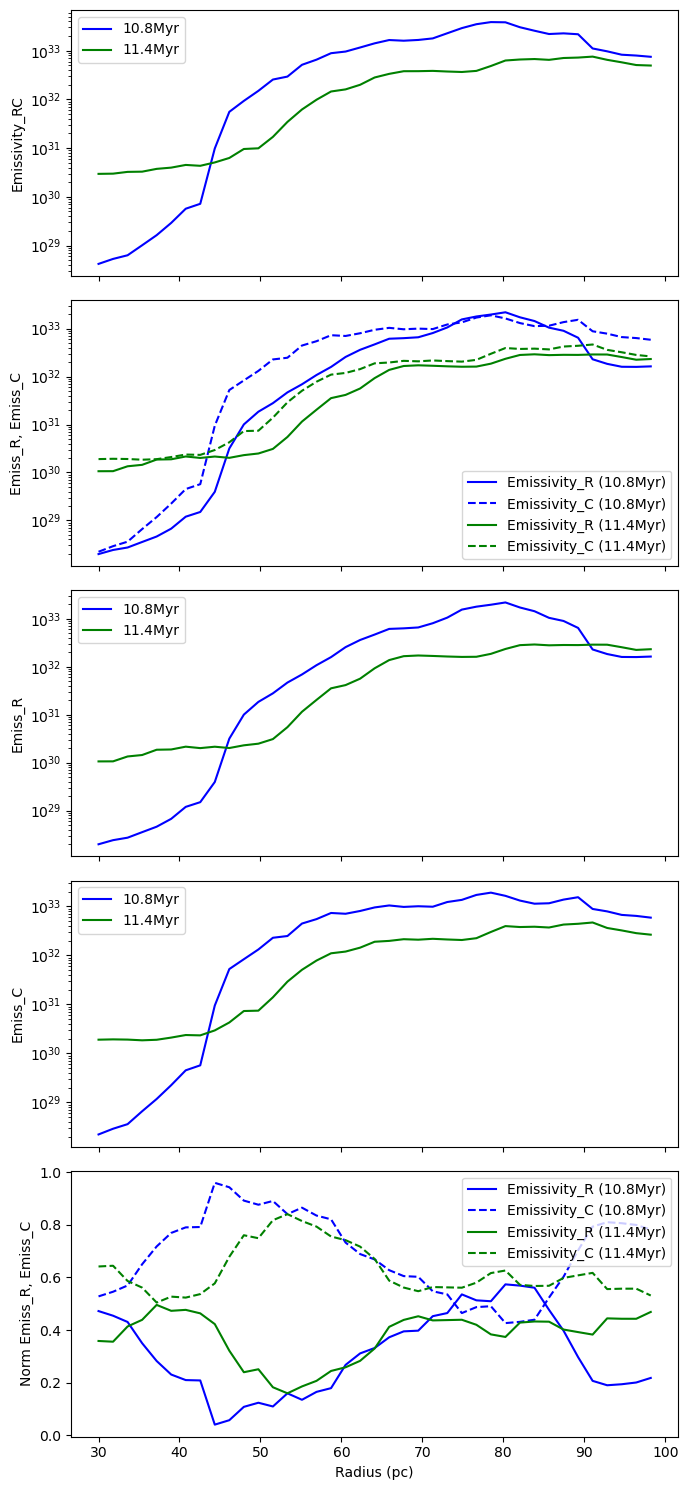

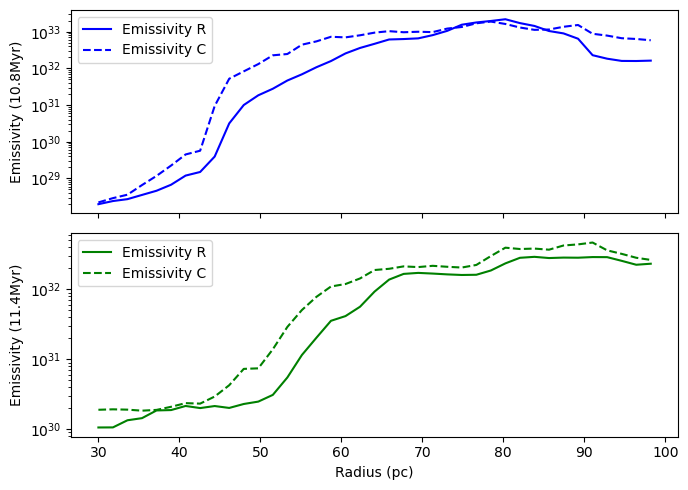

In [10]:
ctr = [-80*pc, -150*pc, 0]
files = ["SILCC_hdf5_plt_cnt_1080", "SILCC_hdf5_plt_cnt_1140"]
names = ["10.8Myr", "11.4Myr"]
colors = ["blue", "green"]
linestyles = ["-", "--"]

#for different times
fig1, ax = plt.subplots(figsize=(7, 15), nrows=5, sharex=True)

#for different emissivities
fig2, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

for idx, data in enumerate(computed_data):
    radii = data['radii']
    sfIhp = data['sfIhp']
    sfIh2 = data['sfIh2']
    sfIha = data['sfIha']
    sMtot = data['sMtot']
    sEmissivity_RC = data['sEmissivity_RC']
    sEmissivity_R = data['sEmissivity_R']
    sEmissivity_C = data['sEmissivity_C']
    frac_emissivity_RC = data['frac_emissivity_RC']
    frac_emissivity_R = data['frac_emissivity_R']
    frac_emissivity_C = data['frac_emissivity_C']
    name = data['name']
    color = colors[idx % len(colors)]
    linestyle = linestyles[idx % len(linestyles)]

    ax[0].semilogy(radii[:-1], sEmissivity_RC, label=name, color=color)  
    ax[0].set_ylabel("Emissivity_RC")

    ax[1].semilogy(radii[:-1], sEmissivity_R, label=f"Emissivity_R ({name})", color=color, linestyle=linestyles[0]) 
    ax[1].semilogy(radii[:-1], sEmissivity_C, label=f"Emissivity_C ({name})", color=color, linestyle=linestyles[1])
    #ax[1].semilogy(radii[:-1], sEmissivity_C, label=f"Emissivity_C ({name})", color=color, linestyle=linestyle)
    ax[1].set_ylabel("Emiss_R, Emiss_C")

    ax[2].semilogy(radii[:-1], sEmissivity_R, label=name, color=color)
    ax[2].set_ylabel("Emiss_R")

    ax[3].semilogy(radii[:-1], sEmissivity_C, label=name, color=color)
    ax[3].set_ylabel("Emiss_C")
    
    ax[4].plot(radii[:-1], frac_emissivity_R, label=f"Emissivity_R ({name})", color=color, linestyle=linestyles[0])
    ax[4].plot(radii[:-1], frac_emissivity_C, label=f"Emissivity_C ({name})", color=color, linestyle=linestyles[1]) 
    ax[4].set_ylabel("Norm Emiss_R, Emiss_C")    
    ax[4].set_xlabel("Radius (pc)")

    for i in range(5):
        ax[i].legend()

    axs[idx].semilogy(radii[:-1], sEmissivity_R, label=f"Emissivity R", color=color, linestyle=linestyles[0])
    axs[idx].semilogy(radii[:-1], sEmissivity_C, label=f"Emissivity C", color=color, linestyle=linestyles[1])
    axs[idx].set_ylabel(f"Emissivity ({name})")
    axs[idx].legend()
    axs[1].set_xlabel("Radius (pc)")
    
fig1.tight_layout()
fig2.tight_layout()

fig1.show()
fig2.show()
fig1.savefig("plot_RC.pdf", dpi=300, bbox_inches="tight")
fig2.savefig("plot_R_C_separate.pdf", dpi=300, bbox_inches="tight")
